In [14]:
import torch
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from rdkit import rdBase
from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D
import matplotlib.cm as cmaps
import IPython.display as ipd


In [26]:
from interpret_utils import load_trained_model, get_node_attribution_gnn, visualize_attribution
from data.data_loaders import preproccess_data, generate_scaffold_split, df_to_graph_list, get_scaffolds

In [48]:
model_args = {
    'num_node_features': 6,
    'edge_attr_dim': 4,
    'u_dim': 6,
    'hidden_dim': 64,
    'output_dim': 1
}


In [49]:
def attach_smiles_to_graphs(graph_list, smiles_list):
    for graph, smi in zip(graph_list, smiles_list):
        graph.smiles = smi
    return graph_list


In [50]:
# Load and preprocess dataset
df = preproccess_data("./data/curated-solubility-dataset.csv")

# Add scaffold column
df["scaffold"] = df["mol"].apply(get_scaffolds)

df["smiles"] = df["mol"].apply(Chem.MolToSmiles)  # Add SMILES column

[02:55:48] WARNING: not removing hydrogen atom without neighbors
[02:55:48] WARNING: not removing hydrogen atom without neighbors
[02:55:48] WARNING: not removing hydrogen atom without neighbors
[02:55:48] WARNING: not removing hydrogen atom without neighbors
[02:55:48] WARNING: not removing hydrogen atom without neighbors
[02:55:48] WARNING: not removing hydrogen atom without neighbors
[02:55:48] WARNING: not removing hydrogen atom without neighbors
[02:55:48] WARNING: not removing hydrogen atom without neighbors
[02:55:48] WARNING: not removing hydrogen atom without neighbors
[02:55:48] WARNING: not removing hydrogen atom without neighbors
[02:55:48] WARNING: not removing hydrogen atom without neighbors
[02:55:48] WARNING: not removing hydrogen atom without neighbors
[02:55:49] WARNING: not removing hydrogen atom without neighbors
[02:55:49] WARNING: not removing hydrogen atom without neighbors
[02:55:49] WARNING: not removing hydrogen atom without neighbors
[02:55:49] WARNING: not r

In [51]:
# Split by scaffold
train_idx, val_idx, test_idx = generate_scaffold_split(df, frac_train=0.8, frac_valid=0.1, frac_test=0.1)
test_df = df.iloc[test_idx].reset_index(drop=True)

In [52]:
# Save SMILES before conversion
test_smiles = test_df["smiles"].tolist()

# Convert test split to graph list
test_dataset = df_to_graph_list(test_df)

# Attach SMILES to graphs
test_dataset = attach_smiles_to_graphs(test_dataset, test_smiles)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [53]:
# Load best model
model = load_trained_model("best_model.pth", model_args=model_args, device="cpu")

/Users/tanishsharma/Documents/uoft/2nd_sem_3rd_yr/ece324/BioSolveAI/interpret_utils.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(mod

In [54]:
sample_index = 0  # change this to try other molecules

scores, data, pred, target = get_node_attribution_gnn(model, test_loader, sample_index=sample_index)
print(f"Predicted: {pred:.4f}, Actual: {target:.4f}")
print("Node Attribution Scores:", scores.tolist())

Predicted: 1.4966, Actual: 1.9912
Node Attribution Scores: [0.0686921551823616, 0.12557747960090637, 0.08008261024951935, 0.15251247584819794, 0.09297221153974533]



==== Node Attribution Heatmap - Sample 0 ====



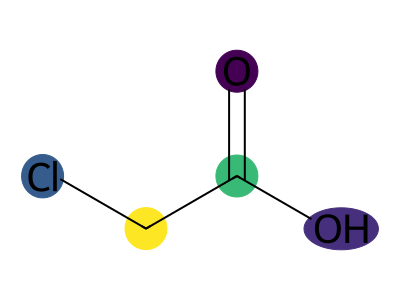

In [55]:
# ===========================
# Visualize Attribution 
# ===========================

# Extract SMILES from data object
smiles = test_dataset[sample_index].smiles if hasattr(test_dataset[sample_index], 'smiles') else None
if smiles is None:
    raise ValueError("SMILES not found in dataset. Make sure each data object includes a `smiles` attribute.")

visualize_attribution(smiles, scores, molecule_name=f"Sample {sample_index}")